## Reference
- Chris McCormick 
- BERT Word Embeddings Tutorial<br>
http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/<br>
- colab<br>
https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=0NmMdkZO8R6q<br>
- Youtube<br>
https://www.youtube.com/watch?v=Hnvb9b7a_Ps&feature=youtu.be<br>
- BERT Fine-Tuning Tutorial with PyTorch<br>
https://mccormickml.com/2019/07/22/BERT-fine-tuning/<br>
- BERT Fine-Tuning Sentence Classification<br>
https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP<br>
- Naver<br>
https://colab.research.google.com/drive/1tIf0Ugdqg4qT7gcxia3tL7und64Rv1dP#scrollTo=P58qy4--s5_x<br>


#1.Set-up

##1.1. Using Colab GPU for Learning

- First of all, we need to select GPU in the runtime menu

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


- To check which GPU type you are using

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


##1.2. Install Hugging Face Library

In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 21.1MB/s 
     |████████████████████████████████| 901kB 45.5MB/s 
     |████████████████████████████████| 3.3MB 51.6MB/s 


In [4]:
!pip install kobert_transformers

In [5]:
!pip install tensorflow
!pip install keras
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 20.0MB/s 


#2.Corpus Data

##2.1.Mount Google Drive to this Notebook instance.

In [6]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- To check the location of this drive

In [8]:
!ls drive/My\ Drive/BERT/SM/KoBERT/Postposition/Data

accuracy     test_Eyse.csv  train_Ey.csv    train_Lo.csv
test_Ey.csv  test_Lo.csv    train_Eyse.csv  t-SNE


##2.2.Install required packages

In [9]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

##2.3.Importing files to generate data

In [10]:
fileDir = "drive/My Drive/BERT/SM/KoBERT/Postposition/Data/test_Ey.csv"
fr = open(fileDir, 'r')
contents= fr.readlines()
fr.close()

test = pd.DataFrame(columns=('index', 'Label', 'Sentence'))
i = 0
index = ""
label = ""
sentence = ""
for content in contents:
    if i == 0:
        pass
    else:
        infos = content.split(",")
        index = infos[0]
        label = int(infos[1])
        sentence = infos[2].replace("\n","")
        test.loc[i] = [index, label, sentence]
    i = i + 1

print(test)

    index Label                  Sentence
1       0     0  아빠도 그런 생각에 아무 말씀이 없으실까요?
2       1     0          모두 겁에 질린 얼굴들이었다.
3       2     0         그녀는 씁쓰름한 기분에 빠진다.
4       3     0     아내는 남편의 소유물에 지나지 않았다.
5       4     0    우리는 번역문화의 후진국에 머물러 있다.
..    ...   ...                       ...
463   462     7          문명에 대한 반항이기도 하다.
464   463     7          과일에는 영양가가 별로 없다.
465   464     7      그러나 왠지 말소리에는 힘이 없었다.
466   465     7       외지의 지주는 농사에 관심이 없다.
467   466     7            옷에 이슬이 묻어 있었다.

[467 rows x 3 columns]


In [11]:
fileDir = "drive/My Drive/BERT/SM/KoBERT/Postposition/Data/train_Ey.csv"
fr = open(fileDir, 'r')
contents= fr.readlines()
fr.close()

train = pd.DataFrame(columns=('index', 'Label', 'Sentence'))
i = 0
index = ""
label = ""
sentence = ""
for content in contents:
    if i == 0:
        pass
    else:
        infos = content.split(",")
        index = infos[0]
        label = int(infos[1])
        sentence = infos[2].replace("\n","")
        train.loc[i] = [index, label, sentence]
    i = i + 1

print(train)

     index Label               Sentence
1        0     0     포화 상태에 있는 용액을 말한다.
2        1     0          금발 생머리에 푸른 눈.
3        2     0     그 지위에는 오르고 싶은 일이다.
4        3     0    "영원한 진리는 신선미에 있거든요.
5        4     0  무엇보다 가짜배기 감정에 젖지 말 것.
...    ...   ...                    ...
4244  4243     7     '산재나면 회사에 유리하게 처리.
4245  4244     7             인사에 응답 없음!
4246  4245     7        오반장은 말에 힘을 주었다.
4247  4246     7    종교 그 자체에도 얽매이지 않는다.
4248  4247     7           요새 게임에 빠져서."

[4248 rows x 3 columns]


- 8 functions of korean postposition '-Ey' <br>
0: FNS (final state)<br>
1: INS (instrumental)<br>
2: GOL (goal)<br>
3: EFF (effector)<br>
4: CRT (criterion)<br>
5: LOC (location)<br>
6: AGT (agent)<br>
7: THM (theme)<br>


In [12]:
print(train[0:20])
print(train.shape)
print(test.shape)

   index Label                    Sentence
1      0     0          포화 상태에 있는 용액을 말한다.
2      1     0               금발 생머리에 푸른 눈.
3      2     0          그 지위에는 오르고 싶은 일이다.
4      3     0         "영원한 진리는 신선미에 있거든요.
5      4     0       무엇보다 가짜배기 감정에 젖지 말 것.
6      5     0                "곧 촬영에 들어간다.
7      6     0         2년 후 수양대군은 왕위에 오른다.
8      7     0                  수포에 돌아가리다.
9      8     0      아이들은 다시금 두려움에 떨기 시작했다.
10     9     0          이 무렵 아내가 심장병에 걸렸다.
11    10     0        아침 햇살에 규혁은 잠에서 깨어났다.
12    11     0                이젠 실전에 들어갔다.
13    12     0       "미군부대 이전운동에 다시 나서야지요.
14    13     0   이별에 앞서 포옹이라도 하려는 연인 사이처럼.
15    14     0       우리 식구는 한참 동안 슬픔에 싸였다.
16    15     0     소형으로 암갈색에 조밀한 가로무늬가 있다.
17    16     0               장발에 떡 벌어진 어깨.
18    17     0  선관위는 결국 일반 투표함부터 개표에 들어갔다.
19    18     0      연극마저도 그런 위기 상황에 처해 있다.
20    19     0            며칠째 나는 불면에 시달렸다.
(4248, 3)
(467, 3)


##2.4.Cleaning the corpus data; remove the punctuations

In [13]:
#정제하기

train['Sentence'] = train['Sentence'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\\n\t]+', " ", regex=True)
test['Sentence'] = test['Sentence'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', " ", regex=True)
train['Sentence'] = train['Sentence'].str.replace(r'\t+', " ", regex=True)
test['Sentence'] = test['Sentence'].str.replace(r'\t+', " ", regex=True)
train['Sentence'] = train['Sentence'].str.replace(r'[\\n]+'," ", regex=True)
test['Sentence'] = test['Sentence'].str.replace(r'[\\n]+'," ", regex=True)

In [14]:
train.head(5)
test.head(5)

,index,Label,Sentence
1,0,0,아빠도 그런 생각에 아무 말씀이 없으실까요
2,1,0,모두 겁에 질린 얼굴들이었다
3,2,0,그녀는 씁쓰름한 기분에 빠진다
4,3,0,아내는 남편의 소유물에 지나지 않았다
5,4,0,우리는 번역문화의 후진국에 머물러 있다


#3.Data processing


##3.1 Preprocessing

- Load the Tokenization.py for KoBERT

In [15]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBert model."""


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

- Convert each sentence to BERT format

In [16]:
# 리뷰 문장 추출
sentences = train['Sentence']
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 포화 상태에 있는 용액을 말한다  [SEP]',
 '[CLS] 금발 생머리에 푸른 눈  [SEP]',
 '[CLS] 그 지위에는 오르고 싶은 일이다  [SEP]',
 '[CLS]  영원한 진리는 신선미에 있거든요  [SEP]',
 '[CLS] 무엇보다 가짜배기 감정에 젖지 말 것  [SEP]',
 '[CLS]  곧 촬영에 들어간다  [SEP]',
 '[CLS] 2년 후 수양대군은 왕위에 오른다  [SEP]',
 '[CLS] 수포에 돌아가리다  [SEP]',
 '[CLS] 아이들은 다시금 두려움에 떨기 시작했다  [SEP]',
 '[CLS] 이 무렵 아내가 심장병에 걸렸다  [SEP]']

- Save the label data

In [17]:
# 라벨 추출
labels = train['Label'].values
labels_re = []
for label in labels:
  labels_re.append(label)
labels = labels_re
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

- Check the KoBertTokenizer

In [18]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])


[CLS] 포화 상태에 있는 용액을 말한다  [SEP]
['[CLS]', '▁포', '화', '▁상태', '에', '▁있는', '▁용', '액', '을', '▁말한다', '[SEP]']


In [19]:
 # 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   2, 4856, 7941, 2680, 6896, 3860, 3494, 6835, 7088, 1964,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [20]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])
print(labels)
print(input_ids)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   2, 1190, 7095, 2004, 6519,    0, 6896, 2822, 6117, 7096,  517, 5591,
        6697, 5591, 6697,  517, 5867, 5760, 5782,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor(7)
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [22]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [23]:
# 리뷰 문장 추출
sentences = test['Sentence']
sentences[:10]

1       아빠도 그런 생각에 아무 말씀이 없으실까요 
2               모두 겁에 질린 얼굴들이었다 
3              그녀는 씁쓰름한 기분에 빠진다 
4          아내는 남편의 소유물에 지나지 않았다 
5         우리는 번역문화의 후진국에 머물러 있다 
6             그래서 도의 본래 모습에 가깝다 
7              당숙의 말은 자신에 차 있었다 
8               여름날 사라는 고민에 빠진다 
9      어젯밤 비몽사몽간에 언뜻 선다님을 뵈었습니다 
10            우리 주력업종이 성숙기에 있다 ’
Name: Sentence, dtype: object

In [24]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 아빠도 그런 생각에 아무 말씀이 없으실까요  [SEP]',
 '[CLS] 모두 겁에 질린 얼굴들이었다  [SEP]',
 '[CLS] 그녀는 씁쓰름한 기분에 빠진다  [SEP]',
 '[CLS] 아내는 남편의 소유물에 지나지 않았다  [SEP]',
 '[CLS] 우리는 번역문화의 후진국에 머물러 있다  [SEP]',
 '[CLS] 그래서 도의 본래 모습에 가깝다  [SEP]',
 '[CLS] 당숙의 말은 자신에 차 있었다  [SEP]',
 '[CLS] 여름날 사라는 고민에 빠진다  [SEP]',
 '[CLS]  어젯밤 비몽사몽간에 언뜻 선다님을 뵈었습니다  [SEP]',
 '[CLS] 우리 주력업종이 성숙기에 있다 ’ [SEP]']

In [25]:
# 라벨 추출
labels = test['Label'].values
labels_re = []
for label in labels:
  labels_re.append(label)
labels = labels_re

In [26]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 아빠도 그런 생각에 아무 말씀이 없으실까요  [SEP]
['[CLS]', '▁아빠', '도', '▁그런', '▁생각', '에', '▁아무', '▁말씀', '이', '▁없', '으', '실', '까', '요', '[SEP]']


In [27]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   2, 3114, 5859, 1201, 2705, 6896, 3111, 1961, 7096, 3270, 7074,
       6738, 5591, 6999,    3,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [28]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [29]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   2, 3114, 5859, 1201, 2705, 6896, 3111, 1961, 7096, 3270, 7074, 6738,
        5591, 6999,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor(0)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [30]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
test_dataloader

#4.Create model

##4.1. Load the KoBERT model; BertForSequenceClassification

In [31]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=8)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

##4.2. Create the functions for checking accuracy rate

In [32]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def FNS_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 0):
        match_num += 1
      if labels_flat[i] == 0:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

def INS_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 1):
        match_num += 1
      if labels_flat[i] == 1:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

def GOL_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 2):
        match_num += 1
      if labels_flat[i] == 2:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

def EFF_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 3):
        match_num += 1
      if labels_flat[i] == 3:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

def CRT_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 4):
        match_num += 1
      if labels_flat[i] == 4:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

def LOC_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 5):
        match_num += 1
      if labels_flat[i] == 5:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

def AGT_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 6):
        match_num += 1
      if labels_flat[i] == 6:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

def THM_flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    match_num = 0
    func_num = 0
    for i in range(0,len(pred_flat)):
      #print(pred_flat[i]," / ",labels_flat[i])
      if (pred_flat[i] == labels_flat[i]) and (labels_flat[i] == 7):
        match_num += 1
      if labels_flat[i] == 7:
        func_num += 1

    if match_num == 0 or func_num == 0:
      return 0
    else:
      return match_num / func_num

In [33]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

##4.3. Train the corpus data with KoBERT

In [34]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 10

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


======== Epoch 1 / 10 ========
Training...

  Average training loss: 1.50
  Training epcoh took: 0:01:16

Running Validation...
  Accuracy: 0.66
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.00
  INS_Accuracy: 0.00
  GOL_Accuracy: 0.00
  EFF_Accuracy: 0.00
  CRT_Accuracy: 0.86
  LOC_Accuracy: 0.99
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.09

  Network visualization  


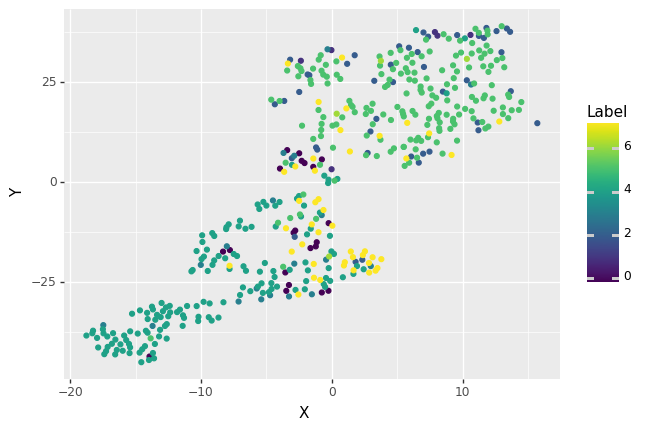

<ggplot: (8777191983077)>

======== Epoch 2 / 10 ========
Training...

  Average training loss: 0.97
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.75
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.02
  INS_Accuracy: 0.00
  GOL_Accuracy: 0.06
  EFF_Accuracy: 0.21
  CRT_Accuracy: 0.97
  LOC_Accuracy: 0.99
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.47

  Network visualization  


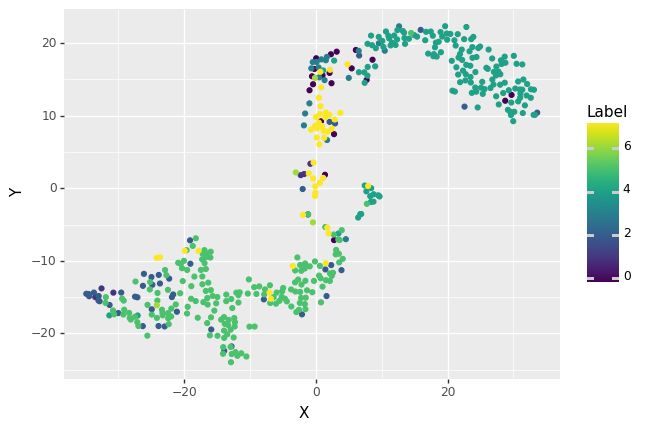

<ggplot: (8777190389697)>

======== Epoch 3 / 10 ========
Training...

  Average training loss: 0.73
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.02
  INS_Accuracy: 0.00
  GOL_Accuracy: 0.12
  EFF_Accuracy: 0.47
  CRT_Accuracy: 0.93
  LOC_Accuracy: 0.97
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.80

  Network visualization  


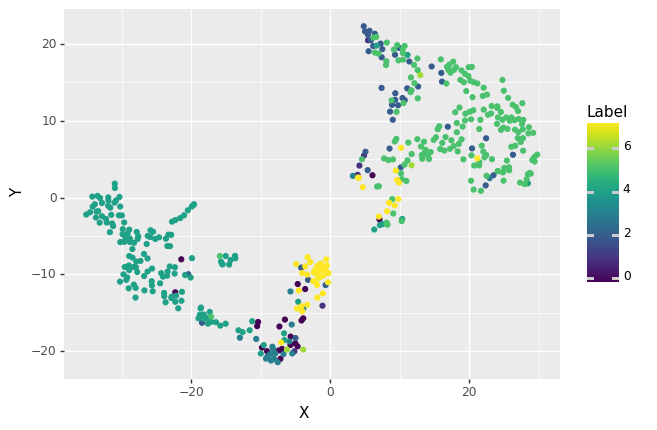

<ggplot: (8777190387373)>

======== Epoch 4 / 10 ========
Training...

  Average training loss: 0.56
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.22
  INS_Accuracy: 0.17
  GOL_Accuracy: 0.28
  EFF_Accuracy: 0.49
  CRT_Accuracy: 0.91
  LOC_Accuracy: 0.96
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.68

  Network visualization  


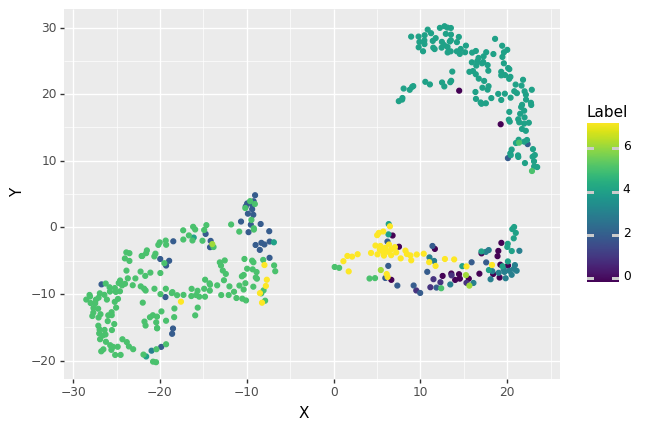

<ggplot: (8777875274597)>

======== Epoch 5 / 10 ========
Training...

  Average training loss: 0.44
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.41
  INS_Accuracy: 0.07
  GOL_Accuracy: 0.23
  EFF_Accuracy: 0.34
  CRT_Accuracy: 0.89
  LOC_Accuracy: 0.96
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.72

  Network visualization  


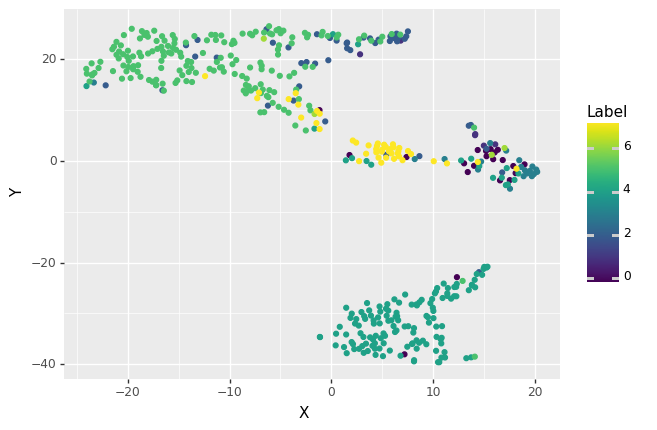

<ggplot: (8777875314677)>

======== Epoch 6 / 10 ========
Training...

  Average training loss: 0.35
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.31
  INS_Accuracy: 0.13
  GOL_Accuracy: 0.18
  EFF_Accuracy: 0.53
  CRT_Accuracy: 0.89
  LOC_Accuracy: 0.96
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.72

  Network visualization  


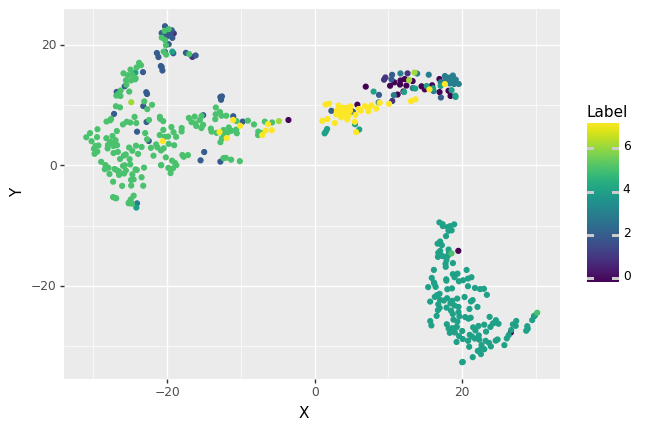

<ggplot: (8777188636865)>

======== Epoch 7 / 10 ========
Training...

  Average training loss: 0.28
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.36
  INS_Accuracy: 0.13
  GOL_Accuracy: 0.17
  EFF_Accuracy: 0.48
  CRT_Accuracy: 0.89
  LOC_Accuracy: 0.96
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.71

  Network visualization  


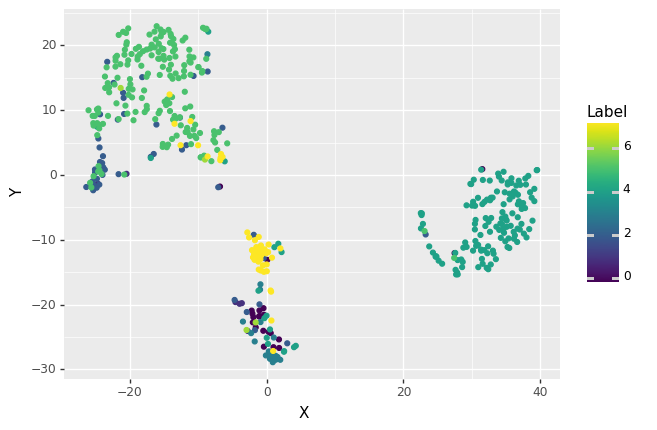

<ggplot: (8777875287117)>

======== Epoch 8 / 10 ========
Training...

  Average training loss: 0.23
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.48
  INS_Accuracy: 0.20
  GOL_Accuracy: 0.30
  EFF_Accuracy: 0.44
  CRT_Accuracy: 0.91
  LOC_Accuracy: 0.95
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.65

  Network visualization  


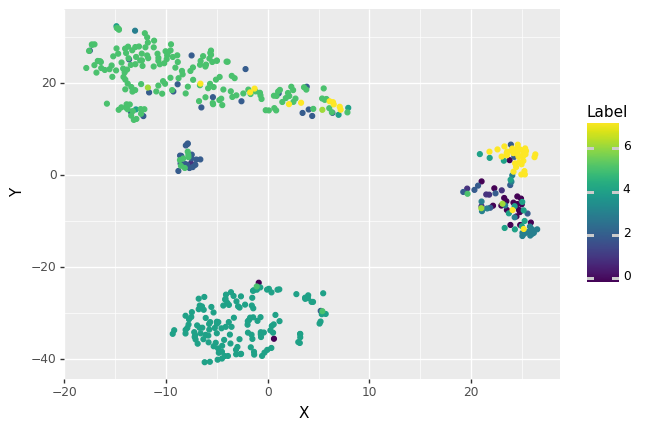

<ggplot: (8777875287161)>

======== Epoch 9 / 10 ========
Training...

  Average training loss: 0.19
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.68
  INS_Accuracy: 0.17
  GOL_Accuracy: 0.23
  EFF_Accuracy: 0.58
  CRT_Accuracy: 0.89
  LOC_Accuracy: 0.95
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.67

  Network visualization  


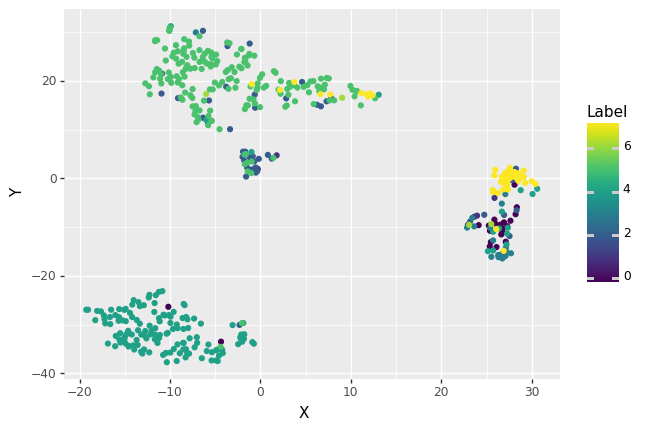

<ggplot: (8777188512757)>

======== Epoch 10 / 10 ========
Training...

  Average training loss: 0.16
  Training epcoh took: 0:01:17

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

  Detail accuracy  
  FNS_Accuracy: 0.56
  INS_Accuracy: 0.20
  GOL_Accuracy: 0.32
  EFF_Accuracy: 0.44
  CRT_Accuracy: 0.90
  LOC_Accuracy: 0.96
  AGT_Accuracy: 0.00
  THM_Accuracy: 0.74

  Network visualization  


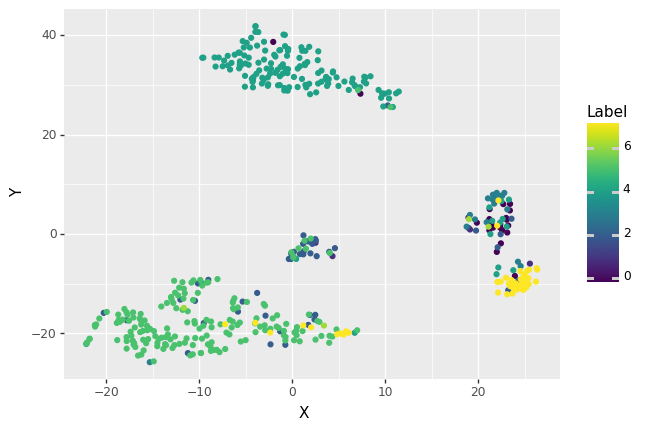

<ggplot: (8777188486541)>

Training complete!

Final result is below!
{'epoch0': {'Total': 0.663, 'Loss': 1.497, 'FNS': 0.0, 'INS': 0.0, 'GOL': 0.0, 'EFF': 0.0, 'CRT': 0.857, 'LOC': 0.988, 'AGT': 0.0, 'THM': 0.093}, 'epoch1': {'Total': 0.749, 'Loss': 0.967, 'FNS': 0.017, 'INS': 0.0, 'GOL': 0.061, 'EFF': 0.206, 'CRT': 0.967, 'LOC': 0.989, 'AGT': 0.0, 'THM': 0.474}, 'epoch2': {'Total': 0.79, 'Loss': 0.728, 'FNS': 0.017, 'INS': 0.0, 'GOL': 0.124, 'EFF': 0.467, 'CRT': 0.931, 'LOC': 0.975, 'AGT': 0.0, 'THM': 0.798}, 'epoch3': {'Total': 0.81, 'Loss': 0.556, 'FNS': 0.222, 'INS': 0.167, 'GOL': 0.277, 'EFF': 0.494, 'CRT': 0.913, 'LOC': 0.961, 'AGT': 0.0, 'THM': 0.677}, 'epoch4': {'Total': 0.799, 'Loss': 0.439, 'FNS': 0.411, 'INS': 0.067, 'GOL': 0.229, 'EFF': 0.339, 'CRT': 0.894, 'LOC': 0.961, 'AGT': 0.0, 'THM': 0.723}, 'epoch5': {'Total': 0.8, 'Loss': 0.355, 'FNS': 0.306, 'INS': 0.133, 'GOL': 0.179, 'EFF': 0.533, 'CRT': 0.89, 'LOC': 0.957, 'AGT': 0.0, 'THM': 0.723}, 'epoch6': {'Total': 0.804, '

In [35]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

final_info = {}

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    FNS_nb_eval_steps, FNS_eval_accuracy = 0, 0
    INS_nb_eval_steps, INS_eval_accuracy = 0, 0
    GOL_nb_eval_steps, GOL_eval_accuracy = 0, 0
    EFF_nb_eval_steps, EFF_eval_accuracy = 0, 0
    CRT_nb_eval_steps, CRT_eval_accuracy = 0, 0
    LOC_nb_eval_steps, LOC_eval_accuracy = 0, 0
    AGT_nb_eval_steps, AGT_eval_accuracy = 0, 0
    THM_nb_eval_steps, THM_eval_accuracy = 0, 0

    epoch_info = {}

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in test_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

        FNS_tmp_eval_accuracy = FNS_flat_accuracy(logits, label_ids)
        FNS_eval_accuracy += FNS_tmp_eval_accuracy
        FNS_nb_eval_steps += 1

        INS_tmp_eval_accuracy = INS_flat_accuracy(logits, label_ids)
        INS_eval_accuracy += INS_tmp_eval_accuracy
        INS_nb_eval_steps += 1

        GOL_tmp_eval_accuracy = GOL_flat_accuracy(logits, label_ids)
        GOL_eval_accuracy += GOL_tmp_eval_accuracy
        GOL_nb_eval_steps += 1

        EFF_tmp_eval_accuracy = EFF_flat_accuracy(logits, label_ids)
        EFF_eval_accuracy += EFF_tmp_eval_accuracy
        EFF_nb_eval_steps += 1

        CRT_tmp_eval_accuracy = CRT_flat_accuracy(logits, label_ids)
        CRT_eval_accuracy += CRT_tmp_eval_accuracy
        CRT_nb_eval_steps += 1

        LOC_tmp_eval_accuracy = LOC_flat_accuracy(logits, label_ids)
        LOC_eval_accuracy += LOC_tmp_eval_accuracy
        LOC_nb_eval_steps += 1

        AGT_tmp_eval_accuracy = AGT_flat_accuracy(logits, label_ids)
        AGT_eval_accuracy += AGT_tmp_eval_accuracy
        AGT_nb_eval_steps += 1

        THM_tmp_eval_accuracy = THM_flat_accuracy(logits, label_ids)
        THM_eval_accuracy += THM_tmp_eval_accuracy
        THM_nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("  Detail accuracy  ")
    print("  FNS_Accuracy: {0:.2f}".format(FNS_eval_accuracy/FNS_nb_eval_steps))
    print("  INS_Accuracy: {0:.2f}".format(INS_eval_accuracy/INS_nb_eval_steps))
    print("  GOL_Accuracy: {0:.2f}".format(GOL_eval_accuracy/GOL_nb_eval_steps))
    print("  EFF_Accuracy: {0:.2f}".format(EFF_eval_accuracy/EFF_nb_eval_steps))
    print("  CRT_Accuracy: {0:.2f}".format(CRT_eval_accuracy/CRT_nb_eval_steps))
    print("  LOC_Accuracy: {0:.2f}".format(LOC_eval_accuracy/LOC_nb_eval_steps))
    print("  AGT_Accuracy: {0:.2f}".format(AGT_eval_accuracy/AGT_nb_eval_steps))
    print("  THM_Accuracy: {0:.2f}".format(THM_eval_accuracy/THM_nb_eval_steps))

    epoch_info["Total"] = round(eval_accuracy/nb_eval_steps,3)
    epoch_info["Loss"] = round(avg_train_loss,3)
    epoch_info["FNS"] = round(FNS_eval_accuracy/FNS_nb_eval_steps,3)
    epoch_info["INS"] = round(INS_eval_accuracy/INS_nb_eval_steps,3)
    epoch_info["GOL"] = round(GOL_eval_accuracy/GOL_nb_eval_steps,3)
    epoch_info["EFF"] = round(EFF_eval_accuracy/EFF_nb_eval_steps,3)
    epoch_info["CRT"] = round(CRT_eval_accuracy/CRT_nb_eval_steps,3)
    epoch_info["LOC"] = round(LOC_eval_accuracy/LOC_nb_eval_steps,3)
    epoch_info["AGT"] = round(AGT_eval_accuracy/AGT_nb_eval_steps,3)
    epoch_info["THM"] = round(THM_eval_accuracy/THM_nb_eval_steps,3)

    final_info["epoch"+str(epoch_i)] = epoch_info


    # 평가모드로 변경
    model.eval()
    test_input_ids = []
    test_input_mask = []
    test_labels = []

    num = 0
    for step, batch in enumerate(test_data):   #467, 128
      # print("batch",batch)
      # 배치를 GPU에 넣음
      batch = tuple(t.to(device) for t in batch)
      
      # 배치에서 데이터 추출
      b_input_ids, b_input_mask, b_labels = batch
      input_ids_arr = []
      input_mask_arr = []

      

      for i in range(0,len(b_input_ids)):
        input_ids_arr.append(int(b_input_ids[i]))
        input_mask_arr.append(int(b_input_mask[i]))

      
      test_input_ids.append(input_ids_arr)
      test_input_mask.append(input_mask_arr)
      test_labels.append(int(b_labels))


    test_input_ids = torch.tensor(test_input_ids)
    test_input_mask = torch.tensor(test_input_mask)
    test_labels = test_labels

    test_input_ids = test_input_ids.to(device)
    test_input_mask = test_input_mask.to(device)


    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(test_input_ids, 
                        token_type_ids=None, 
                        attention_mask=test_input_mask)
        

    sentence_vecs_sum = outputs[0]

    sentence_array = []
    for i in range(0,len(sentence_vecs_sum)):
      each_array = []
      for j in range(0,len(sentence_vecs_sum[i])):
        each_array.append(float(sentence_vecs_sum[i][j]))
      sentence_array.append(each_array)

    initial_df = pd.DataFrame(sentence_array)

    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(initial_df)

    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],'Y':tsne_obj[:,1],'Label':test_labels})

    # tsne_df.to_csv("drive/My Drive/BERT/SM/KoBERT/Postposition/Data/t-SNE/Ey_tSNE_epoch_"+str(epoch_i)+".csv")

    import numpy as np   
    import pandas as pd 
    from plotnine import *

    print("")
    print("  Network visualization  ")
    print(ggplot(tsne_df, aes(x='X', y='Y')) + geom_point(aes(colour = 'Label')))

print("")
print("Training complete!")
print("")
print("Final result is below!")
print(final_info)

# f = open("drive/My Drive/BERT/SM/KoBERT/Postposition/Data/accuracy/Ey_accuracy_epoch_"+str(epochs)+".txt", 'w')
# f.write(str(final_info))
# f.close()

In [ ]:
model.save_pretrained('drive/My Drive/BERT/SM/KoBERT/Postposition/Model/')
tokenizer.save_pretrained('drive/My Drive/BERT/SM/KoBERT/Postposition/Model/')

- additional test with test_dataloader

In [36]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):  #15
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
        
    # 로스 구함
    logits = outputs[0]  #32 , 8

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.81
Test took: 0:00:03


#5.Create function using trained model

##5.1. Create functions

In [ ]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = KoBertTokenizer.from_pretrained('simonmun/Ey_SentenceClassification')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1324: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [ ]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("simonmun/Ey_SentenceClassification", num_labels=8)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

##5.2. Check the result with real sentence

In [ ]:
logits = test_sentences(['가방이 집에 있어.'])

print(logits)
print(np.argmax(logits))

[[-2.3136582 -1.6808176 -0.7284922 -1.6234565 -1.5049595  9.541716
  -1.4227811 -1.0589652]]
5


In [ ]:
logits = test_sentences(['갈대가 바람에 살랑살랑 움직입니다.'])

print(logits)
print(np.argmax(logits))

[[-1.320752  -0.0604541 -1.2098627  8.686989  -1.232854  -1.1534134
  -0.7995728 -1.1843923]]
3
